## Getting started

Music21 encapsulates most concepts from music theory in some kind of object. There are pitches, notes intervals chords. Melodies are created by packing notes and chords into stream objects and all the objects come with handy methods to modify them or create related new objects.

Because there are a bunch of different classes it is best to import then all in the first line:

In [1]:
from music21 import *

Creating a note is very easy. It's just a `Note` object from the `note` submodule. You could create it with a `Pitch` object but music21 has short string notations which are very easy: `'C4'` simply creates a C in the fourth octave, the base note of the C major scale. If no duration is given music21 assumes a quarter note but the `quarterLength` parameter sets it right in the constructor. The method `.show()` creates a PNG image of the nostation an the jupyter notebook displadys it directly beneath the cell.

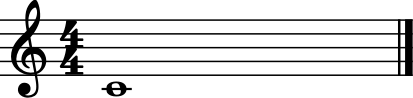

In [2]:
c = note.Note('C4', quarterLength=4)
c.show()

music21 can also create a midi version of the object. You can unse the embedded player to play it inside of the notebook.

In [3]:
c.show('midi')

## Creating a random chord sequence

By transposing the base note along the intervals major third `M3`, minor third `m3` and perfect fith `P5` one can create chords. Building a random sequence out of these creates a first algorithmic composition.

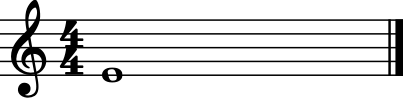

In [4]:
e = c.transpose('M3')
e.show()

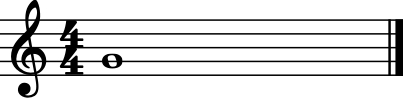

In [5]:
g = e.transpose('m3')
g.show()

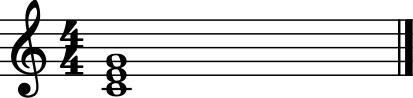

In [6]:
c_dur = chord.Chord([c, e, g])
c_dur.show()

In [7]:
c_dur.show('midi')

In [8]:
from circle_of_fiths import MajorMinor, major, minor

In [9]:
def build_chord(base_tone: note.Note, mode: MajorMinor = major):
    intervals = ('M3', 'm3') if mode == major else ('m3', 'M3')
    second_tone = base_tone.transpose(intervals[0])
    third_tone = second_tone.transpose(intervals[1])
    return chord.Chord([base_tone, second_tone, third_tone])

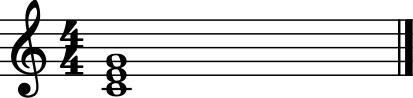

In [10]:
c_dur = build_chord(c, MajorMinor.MAJOR)
c_dur.show()

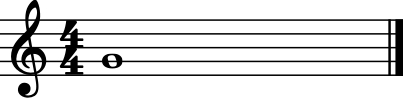

In [11]:
g = c.transpose('P5')
g.show()

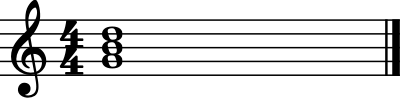

In [12]:
g_dur = build_chord(g, major)
g_dur.show()

In [13]:
stream.Stream([c_dur, g_dur]).show('midi')

5


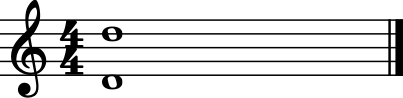

In [14]:
d2 = g.transpose('P5')
print(d2.octave)
d1 = note.Note('D4', quarterLength=4)
chord.Chord([d1, d2]).show()

In [15]:
def transpose_to_fourth_octave(tone: note.Note):
    while tone.octave > 4:
        tone = tone.transpose('P-8')
    while tone.octave < 4:
        tone = tone.transpose('P8')
    return tone

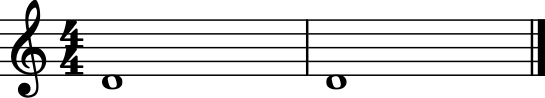

In [16]:
stream.Stream([d1, transpose_to_fourth_octave(d2)]).show()

In [17]:
from circle_of_fiths import CircleOfFifths, major, minor
cf = CircleOfFifths()

In [18]:
from random import choice, randint
def create_random_chord_stream(length, note_length=2):
    directions = [(major, -1), (minor, -1), 
                  (major, 0), (minor, 0), 
                  (major, 1), (minor, 1)]
    mode = choice((major, minor))
    chord_number = randint(0, 11)
    base_note = cf.base_note(chord_number)
    base_note.quarterLength = 2
    chord = build_chord(base_note, mode)
    s = stream.Stream()
    s.append(chord)
    for i in range(length):
        changing_directions = directions.copy()
        changing_directions.pop(directions.index((mode, 0)))
        direction = choice(changing_directions)
        chord_number += direction[1]
        base_note = cf.base_note(chord_number % 12)
        base_note.quarterLength = 2
        base_note = transpose_to_fourth_octave(base_note)
        chord = build_chord(base_note, direction[0])
        s.append(chord)
        mode = direction[0]
    return s

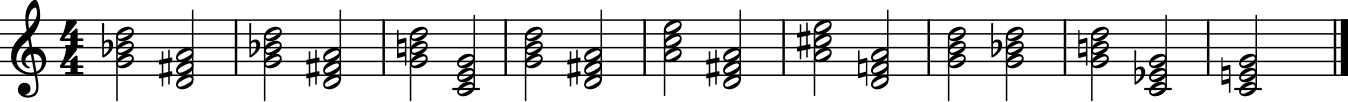

In [19]:
chord_stream = create_random_chord_stream(16)
chord_stream.show()

In [20]:
chord_stream.show('midi')

## Chord inversions

By transposing some notes of a chord a full octave inversions of the chord are created. These can sound lower than the previous chord even if the base tone of the chord is a fith higher.

In [21]:
def build_chord(base_tone: note.Note, mode: MajorMinor = major, inversion=0):
    intervals = ('M3', 'm3') if mode == major else ('m3', 'M3')
    second_tone = base_tone.transpose(intervals[0])
    third_tone = second_tone.transpose(intervals[1])
    if inversion >= 1:
        base_tone = base_tone.transpose('P8')
    if inversion >= 2:
        second_tone = second_tone.transpose('P8')
    return chord.Chord([base_tone, second_tone, third_tone])

[<music21.note.Note E>, <music21.note.Note G>, <music21.note.Note C>]
[<music21.note.Note G>, <music21.note.Note C>, <music21.note.Note E>]


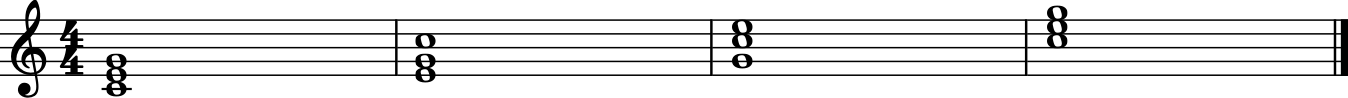

In [22]:
c_6_dur = build_chord(note.Note('C4', quarterLength=4), major, inversion=1)
print(sorted(c_6_dur.notes, key=lambda x: x.pitch))
c_quart_6_dur = build_chord(note.Note('C4', quarterLength=4), major, inversion=2)
print(sorted(c_quart_6_dur.notes, key=lambda x: x.pitch))
stream.Stream([c_dur, c_6_dur, c_quart_6_dur, c_dur.transpose('P8')]).show()

In [23]:
def get_lowest_note_of_chord(chord: chord.Chord):
    return sorted(chord.notes, key=lambda x: x.pitch)[0]

In [24]:
def transpose_chord_to_fourth_octave(chord: chord.Chord):
    while get_lowest_note_of_chord(chord).octave > 4:
        chord = chord.transpose('P-8')
    while get_lowest_note_of_chord(chord).octave < 4:
        chord = chord.transpose('P8')
    return chord

In [25]:
def build_chord_and_select_inversion(base_tone: note.Note, mode: MajorMinor, prev_base_tone: note.Note):
    chord = transpose_chord_to_fourth_octave(build_chord(base_tone, mode, inversion=0))
    chord6 = transpose_chord_to_fourth_octave(build_chord(base_tone, mode, inversion=1))
    chordq6 = transpose_chord_to_fourth_octave(build_chord(base_tone, mode, inversion=1))
    return sorted([chord, chord6, chordq6], 
                  key=lambda x: interval.Interval(prev_base_tone, get_lowest_note_of_chord(x)).semitones)[0]

In [26]:
def create_random_chord_stream(length, note_length=2):
    directions = [(major, -1), (minor, -1), 
                  (major, 0), (minor, 0), 
                  (major, 1), (minor, 1)]
    mode = choice((major, minor))
    chord_number = randint(0, 11)
    base_note = cf.base_note(chord_number)
    base_note.quarterLength = note_length
    chord = build_chord(base_note, mode)
    s = stream.Stream()
    s.append(chord)
    for i in range(length):
        changing_directions = directions.copy()
        changing_directions.pop(directions.index((mode, 0)))
        direction = choice(changing_directions)
        chord_number += direction[1]
        base_note = cf.base_note(chord_number % 12)
        base_note.quarterLength = note_length
        base_note = transpose_to_fourth_octave(base_note)
        current_base_note = get_lowest_note_of_chord(chord)
        chord = build_chord_and_select_inversion(base_note, direction[0], current_base_note)
        s.append(chord)
        mode = direction[0]
    return s

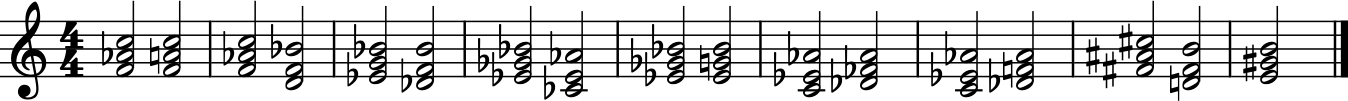

In [27]:
chord_stream = create_random_chord_stream(16)
chord_stream.show()

In [28]:
chord_stream.show('midi')

## Never ending Melody

By selecting only tones from chords there is no danger having gravely mistoned intervals. The length of the notes can be retrieved from the rythm. For the melody the algorithm can now use a similar approach as before: Starting with a shape of random up and down movements of the intervals it can modify the intervals slightly after one repetition. This ensures that there is always some degree of predictability for the listener while adding some kind of surprise with each measure.

In [29]:
# basistonart wählen
# Akkordfolge (2 Akkorde pro Takt, nicht-wechsel erlaubt) für den Satz (movement) wählen
  # Akkordfolge muss auf Kadenz enden: I - iv - V - I
# Zufälligen Rhythmus für Takte (measures) A und B wählen.
  # Prase 2 nutzt A und modifiziert B
  # Phrase 3 behält A und behält das modifizierte B
  # Phrase 4 modifiziert A und behält das modifizierte B ohne weitere Modifikation
# Zufällige Intervalle für die Bewegung in Phrase 1 wählen.
  # Intervalle entsprechend der Akkorde in Phrase 2 wiederholen.
  # Für Phrase 3 Intervalle an einer zufälligen Stelle modifizieren.
  # Modifizierte Intervalle in Phrase 4 möglichst wiederholen.
# Für den nächsten Satz (movement) Akkordfolge neu erzeugen, 
# bei Rhythmus und Intervallen den vorherigen Satz modifizieren.

def circle_of_fiths_chord_neighbour(base_tone: note.Note):
    pass # C major next to A minor